Iterasjon  0  L =  1.28252041635867 
Iterasjon  1  L =  1.4916173022268 
Iterasjon  2  L =  3.416255720316021 
Iterasjon  3  L =  8.756217704906078 
Iterasjon  4  L =  14.150802464454898 
Iterasjon  5  L =  19.272806374266644 
Iterasjon  6  L =  24.342993973861663 
Iterasjon  7  L =  26.94942264411474 
Iterasjon  8  L =  30.835714923978777 
Iterasjon  9  L =  34.8474455232409 
Iterasjon  10  L =  37.73075049381762 
Iterasjon  11  L =  39.96222824842582 
Iterasjon  12  L =  41.33409130681485 
Iterasjon  13  L =  44.1149092605512 
Iterasjon  14  L =  46.793438067280306 
Iterasjon  15  L =  49.959660512251425 
Iterasjon  16  L =  54.40757274498327 
Iterasjon  17  L =  60.33007641874101 
Iterasjon  18  L =  64.7215212747245 
Iterasjon  19  L =  74.57564983255838 


c:\Users\Bruker\Documents\04_STUDIE\VitBer\TMA4320-IndMat\VitBer_indMat\prosjekt_2_utlevert_kode\layers.py:168: RuntimeWarning: divide by zero encountered in log
  q = -np.log(p)


Iterasjon  20  L =  inf 
Iterasjon  21  L =  inf 
Iterasjon  22  L =  inf 
Iterasjon  23  L =  inf 
Iterasjon  24  L =  inf 
Iterasjon  25  L =  inf 
Iterasjon  26  L =  inf 
Iterasjon  27  L =  inf 
Iterasjon  28  L =  inf 
Iterasjon  29  L =  inf 
Iterasjon  30  L =  inf 
Iterasjon  31  L =  inf 
Iterasjon  32  L =  inf 
Iterasjon  33  L =  inf 
Iterasjon  34  L =  inf 
Iterasjon  35  L =  inf 
Iterasjon  36  L =  inf 
Iterasjon  37  L =  inf 
Iterasjon  38  L =  inf 
Iterasjon  39  L =  inf 
Iterasjon  40  L =  inf 
Iterasjon  41  L =  inf 
Iterasjon  42  L =  inf 
Iterasjon  43  L =  inf 
Iterasjon  44  L =  inf 
Iterasjon  45  L =  inf 
Iterasjon  46  L =  inf 
Iterasjon  47  L =  inf 
Iterasjon  48  L =  inf 
Iterasjon  49  L =  inf 
Iterasjon  50  L =  inf 
Iterasjon  51  L =  inf 
Iterasjon  52  L =  inf 
Iterasjon  53  L =  inf 
Iterasjon  54  L =  inf 
Iterasjon  55  L =  inf 
Iterasjon  56  L =  inf 
Iterasjon  57  L =  inf 
Iterasjon  58  L =  inf 
Iterasjon  59  L =  inf 


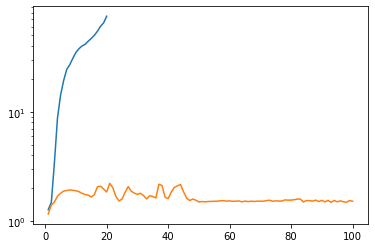

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from training_algorithm import TrainingAlgorithm

nn_adding_0, mean_losses_adding_0 = TrainingAlgorithm(1) #addisjonsproblem

nn_adding_1, mean_losses_adding_1 = TrainingAlgorithm(0) #sorteringsproblem

n = np.arange(1, len(mean_losses_adding_1)+1)
plt.yscale("log")
plt.plot(n, mean_losses_adding_0, label='Addisjonsproblem')
plt.plot(n, mean_losses_adding_1, label='sorteringsproblem')
plt.show()

Under trening av algoritmen opplever vi to større feil ved minimering av Loss-funksjonen:\
**Feil 1:** Både step_Adam og step_gd gir en økning i verdien til Loss-funksjonen. Step_Adam varierer før den divergerer, til forskjell fra step_gd som er helt lineær og svakt økende.\
**Feil 2:** Bruk av step_Adam gir "RuntimeWarning: divide by zero encountered in log q = -np.log(p)" for attention forward. 

Under debuggingen  har vi utforsket følgende hypoteser: 
1) Matriseelementer i p i attention forward er lik null, og np.log(p) gir feilmenldinger da logaritmen til 0 ikke eksisterer. Det er flere grunner til at p kan bli lik null, blant dem:
    - self.Y = onehot(y,m) blir null: dersom onehot ikke fungerer som den skal og og ikke leverer verdier lik 1 vil den kunne gi en null-matrise for self.Y = onehot(y,m). Vi sjekket derfor max-verdien i hver kolonne til onehot-matrisen og fikk at samtlige hadde en verdi 1. Onehot fungerer derfor tilsynelatende som den skal. 
    - self.Y_hat = Z[:,:,-r:] blir null: dersom Z = nn.forward(X) ikke fungerer slik den skal vil den kunne gi ut en Z som blir enten null eller veldig liten. Til å teste dette printet vi retur-verdien til hvert lag i forward. Vi oppdager at flere verdier i softmax divergerer mot null men tester samtidig kollonnesummene og ser at disse er lik 1 (eller tilnærmet lik +-10**-8). Siden Softmax er en sannsynlighetsfordeling kan det stemme at flere av elementene har sannsynligheter som er nærmest lik null, og siden kollonnesummene stemmer finner vi ingen åpenbare kilder til feil for Z.
2) Dimensjonsfeil 
    - dersom slizingen av Z ikke er gjort riktig og gir feil self.Y_hat = Z kan dette være en kilde til feil. Her sjekket vi derfor at både Y_hat og Y har like dimensjoner ("legge inn dim her")
    - feil bruk av einsum vil kunne gi feil dimensjoner som kan gå utover f.eks np.sum()-funksjonene som behandler sannsynlighetsfordelingene i forward pass eller på andre måter gjøre at informasjon går tapt i nettverket. Vi printet "shapen" til matrisene og forsikret oss om at de gir ut riktige dimensjoner. 
    - sjekket bruk av np.sum(arr,axis=)
3) Feil i Adam (løser ikke problemet ved bruk av step_gd dvs. tilsynelatende ligger problemet et annet sted?)
    - hvada?
4) Feil i training_algorithm
    - Testet for flere attention lag: Ved økning av lag gikk loss-funksjonen fortere mot inf, flere att. løser ikke problemet
    - step_size har sammenheng med konvergenshastighen, og en endring i step_size vil påvirke hvor raskt eller sakte algoritmen konvergerer mot et optimalt punkt. I vårt tilfelle hvor funkjonen konvergerer vekk fra det optimale erfarte vi derfor at en mindre step_size ga funksjonen flere verdier før inf ble nådd. Selv om vi med en mindre step_size kunne se at Loss-funksjonen for enkelte områder ble mindre for step_adam, så vi likevel ikke noe tegn til at Loss-fungeren konvergerte til en lavere verdi. Vi vurderer derfor ikke læringsraten som en sannsynlig feilkilde. 
5) Feil i implimentering av algoritmer:
    - Ut i fra feilen vår og konklusjoner fra punkt 1) kunne det virke som det kunne være noe feil i implimenteringen av algoritmer, vi fant, etter mye stirring, en feil i CrossEntropy.Backward, vi hadde "dLdY = (1/self.n)*(np.multiply(padded_Y,self.Z+eps))" mens det skulle være "dLdY = -(1/self.n)*(padded_Y/(self.Z+eps))", dette rettet dessvere ikke opp i alt, men loss-funksjonen konvergerer ikke mot inf lenger!
 
    



